In [ ]:
!pip3 install sklearn
!pip3 install seaborn

In [7]:
import numpy as np
import csv
import re
import random
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics

In [13]:
#Loading files
rstars = open('Predykcyjne_Stars_.csv', mode='r')
rgchar = open('Predykcyjne_guest_characteristics_.csv', mode='r')
rgcuis = open('Predykcyjne_guest_cuisine_.csv', mode='r')
rgpaym = open('Predykcyjne_guest_payment_.csv', mode='r')
rrcuis = open('Predykcyjne_restaurant_cuisine.csv', mode='r')
rropen = open('Predykcyjne_restaurant_open.csv', mode='r')
rrpark = open('Predykcyjne_restaurant_parking.csv', mode='r')
rrpaym = open('Predykcyjne_restaurant_payment.csv', mode='r')
#info = open('README_StudentsDataHack_2021_predykcyjne.txt', mode='r')

#Reading files as ordered dicts (per line)
stars = csv.DictReader(rstars)

gchar = csv.DictReader(rgchar)
gcuis = csv.DictReader(rgcuis)
gpaym = csv.DictReader(rgpaym)

rcuis = csv.DictReader(rrcuis)
ropen = csv.DictReader(rropen)
rpark = csv.DictReader(rrpark)
rpaym = csv.DictReader(rrpaym)

#Processing data - almost no dict comprehension because csv opens everything once 

#Stars
#Redundance for convenience 
restars = {} #restaurants as keys
ratings = {}
for line in stars:
  if line['restaurantID'] not in restars.keys():
    restars[line['restaurantID']] = {line['guestID']: line['stars']}
  else:
    restars[line['restaurantID']][line['guestID']] = line['stars']
  if line['restaurantID'] not in ratings.keys():
    ratings[line['restaurantID']] = {}
  else:
    if line['stars'] not in ratings[line['restaurantID']].keys():
      ratings[line['restaurantID']][line['stars']] = []
    ratings[line['restaurantID']][line['stars']].append(line['guestID'])

#Guests
gecuis = {}
for line in gcuis:
  if line['guestID'] not in gecuis.keys():
    gecuis[line['guestID']] = []
  gecuis[line['guestID']].append(line['cuisine'])

gepaym = {}
for line in gpaym:
  if line['guestID'] not in gepaym.keys():
    gepaym[line['guestID']] = []
  gepaym[line['guestID']].append(line['payment'])

guests = {}  #A filtered map: guestID = dict of all characteristics, without guests with unknown values
gechar = {line['guestID']:{k:v for (k,v) in line.items()} for line in gchar} #if '?' not in line.values() 
for k,v in gechar.items():
  del gechar[k]['guestID']
  del gechar[k]['']
  if k in gecuis.keys():
    gechar[k]['cuisine'] = gecuis[k]
  else:
    gechar[k]['cuisine'] = []
  if k in gepaym.keys():
    gechar[k]['payment'] = gepaym[k]
  else:
    gechar[k]['payment'] = []
  if [] not in gechar[k].values() and '?' not in gechar[k].values():
    guests[k] = v #['U1024'] test case for filtering

#Restaurants
#repark = {line['restaurantID']:line['parking_lot'] for line in rpark}
restaurants = {line['restaurantID']:{'parking_lot':line['parking_lot']} for line in rpark}

repaym = {}
for line in rpaym:
  if line['restaurantID'] not in repaym.keys():
    repaym[line['restaurantID']] = []
  repaym[line['restaurantID']].append(line['payment'])

recuis = {}
for line in rcuis:
  if line['restaurantID'] not in recuis.keys():
    recuis[line['restaurantID']] = []
  recuis[line['restaurantID']].append(line['cuisine'])

#nightmare
reopen = {}
for line in ropen:
  if line['restaurantID'] not in reopen.keys():
    reopen[line['restaurantID']] = {'Mon':[],'Tue':[],'Wed':[],'Thu':[],'Fri':[],'Sat':[],'Sun':[]}
  days = [item for item in line['days;;;;;;;;'].split(';') if item != '']
  for day in days:
    if day not in reopen[line['restaurantID']].keys():
      reopen[line['restaurantID']][day] = []
    l = [pair  for pair in line['hours'].split(';') if pair != '']
    for i in l:
      if tuple(i.split('-')) not in reopen[line['restaurantID']][day]:
        reopen[line['restaurantID']][day].append(tuple(i.split('-'))) #not very professional but should work
  days = None
'''
for k,v in reopen.items():
  print(k,v)
'''
frestaurants = {} #filtered restaurants
for k,v in restaurants.items():
  if k in recuis.keys():
    restaurants[k]['cuisine'] = recuis[k]
  if k in repaym.keys():
    restaurants[k]['payments'] = repaym[k]
  if k in restars.keys():
    restaurants[k]['stars'] = restars[k]
  if k in ratings.keys():
    restaurants[k]['ratings'] = ratings[k]
  if k in reopen.keys():
    restaurants[k]['days'] = reopen[k]
  if len(restaurants[k].keys()) == 6:
    frestaurants[k] = v

'''
for key in frestaurants.keys():
  print(frestaurants[key])
'''
print(frestaurants)
print(guests)
print(restars)
print(ratings)

{'135109': {'parking_lot': 'none', 'cuisine': ['Italian'], 'payments': ['cash'], 'stars': {'U1030': '0', 'U1020': '2', 'U1051': '1', 'U1041': '1'}, 'ratings': {'2': ['U1020'], '1': ['U1051', 'U1041']}, 'days': {'Mon': [('08:00', '21:00')], 'Tue': [('08:00', '21:00')], 'Wed': [('08:00', '21:00')], 'Thu': [('08:00', '21:00')], 'Fri': [('08:00', '21:00')], 'Sat': [('08:00', '21:00')], 'Sun': [('08:00', '21:00')]}}, '135106': {'parking_lot': 'none', 'cuisine': ['Mexican'], 'payments': ['cash', 'VISA', 'MasterCard-Eurocard'], 'stars': {'U1055': '2', 'U1126': '2', 'U1024': '1', 'U1004': '2', 'U1106': '0', 'U1016': '2', 'U1101': '0', 'U1078': '2', 'U1002': '1'}, 'ratings': {'2': ['U1126', 'U1004', 'U1016', 'U1078'], '1': ['U1024', 'U1002'], '0': ['U1106', 'U1101']}, 'days': {'Mon': [('18:00', '23:30')], 'Tue': [('18:00', '23:30')], 'Wed': [('18:00', '23:30')], 'Thu': [('18:00', '23:30')], 'Fri': [('18:00', '23:30')], 'Sat': [('18:00', '23:30')], 'Sun': [('18:00', '21:00')]}}, '135104': {'park

In [47]:
def prepare_data(restaurant: str='', guest: str='', restaurant_db = frestaurants, guest_db = guests):
  cuisine_param = 0
  payment_param = 0  
  parking_param = 0
  luxury_param = 0
  company_param = 0
  drinking_param = 0
  cuisine_match = 0

  if guest not in guest_db.keys():
    return []
  
  if restaurant not in restaurant_db.keys():
    return []

  for preference in guest_db[guest]['cuisine']:
    if preference in restaurant_db[restaurant]['cuisine']:
      cuisine_match += 1
  if cuisine_match != 0:
    cuisine_param = 1

  payment_match = 0
  for preference in guest_db[guest]['payment']:
    if preference in restaurant_db[restaurant]['payments']:
      payment_match += 1
  if payment_match != 0:
    payment_param = 1

  if guest_db[guest]['transport'] == 'car' and restaurant_db[restaurant]['parking_lot'] is not 'None':
    parking_param = 1
  elif guest_db[guest]['transport'] == 'car' and restaurant_db[restaurant]['parking_lot'] == 'None':
    parking_param = 0

  if guest_db[guest]['budget'] == 'high' and restaurant_db[restaurant]['parking_lot'] == 'valet parking':
    luxury_param = 1
  elif guest_db[guest]['budget'] != 'high' and restaurant_db[restaurant]['parking_lot'] == 'valet parking':
    luxury_param = 0

  if guest_db[guest]['company'] in restaurant_db[restaurant]['cuisine']:
    company_param = 1
  if guest_db[guest]['company'] == 'family' and 'bar' in restaurant_db[restaurant]['cuisine']:
    company_param = 0
  elif guest_db[guest]['drinker'] != 'abstemious' and 'bar' in restaurant_db[restaurant]['cuisine']:
    drinking_param = 1 

  result = np.array([cuisine_param, payment_param, parking_param, luxury_param, company_param, drinking_param])
  return result

rt = np.zeros(1)
ds = np.zeros(6)
for restaurant in restars.keys():
  for guest in restars[restaurant].keys():
    result = prepare_data(restaurant = restaurant, guest = guest)
    if result != []:
      rt = np.vstack((rt, np.array([int(restars[restaurant][guest])])))
      ds = np.vstack((ds, result))

#print(ds[:,1])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


No handles with labels found to put in legend.


Accuracy: 0.3888888888888889


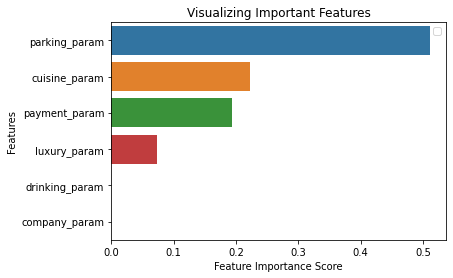

In [58]:
data = pd.DataFrame({
  'cuisine_param': ds[:,0],
  'payment_param': ds[:,1],
  'parking_param': ds[:,2],
  'luxury_param': ds[:,3],
  'company_param': ds[:,4],
  'drinking_param': ds[:,5],
  'stars': rt[:,0]
})
data.head()

X=data[['cuisine_param', 'payment_param', 'parking_param', 'luxury_param', 'company_param', 'drinking_param']] 
y=data['stars']

# Split dataset into training set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3) #70% training and 30% test

#Create a Gaussian Classifier
clf=RandomForestClassifier(n_estimators=100)

#Train the model using the training sets y_pred=clf.predict(X_test)
clf.fit(X_train,y_train)
y_pred=clf.predict(X_test)

# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))


feature_imp = pd.Series(clf.feature_importances_,index=['cuisine_param', 'payment_param', 'parking_param', 'luxury_param', 'company_param', 'drinking_param']).sort_values(ascending=False)
feature_imp

# Creating a bar plot
sns.barplot(x=feature_imp, y=feature_imp.index)

# Add labels to your graph
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.legend()
plt.show()
